#### paper review assignment
# Playing Atari with Deep Reinforcement Learning

# Abstract

강화 학습을 통해 control policies를 성공적으로 학습시킨 딥러닝 모델을 소개한다. Q-learning으로 학습된 CNN 모델을 사용한다.

# 1. Introduction

이미지나 음성같은 고차원 sensory inputs으로부터 agent를 학습시키는 것은 강화학습의 큰 숙제였다. 최근 딥러닝의 발전은 고차원 feature 추출을 가능하게 만들었으나, 강화학습에 딥러닝을 적용하는 과정에서 몇 가지 문제점을 발견하였다.

- 대부분의 딥러닝은 라벨링된 학습 데이터를 요구한다.  
→  강화학습은 sparse, noisy, delayed 한 scalar reward signal를 통해 학습한다. (이러한 action과 reward 사이의 지연은 지도학습에서는 볼 수 없다.)
- 대부분의 딥러닝은 데이터의 독립(i.i.d)을 가정한다.  
→  강화학습에서는 sequence에 따라 states끼리 강한 상관관계를 띈다. (time series data)
- 강화학습에서 데이터의 분포는 새로운 행동을 취할 때마다 바뀐다.

이 논문은 CNN이 이러한 한계를 극복하고 강화학습 환경에서 control policies를 학습할 수 있다는 것을 입증할 것이다.  
신경망은 `Q-learning과 SGD`로 학습하고, 상관성과 분포의 가변성 문제에 맞서기 위해 랜덤추출로 학습 데이터 분포의 균형을 잡아주는 `experience replay mechanism`을 사용하기로 한다.

하나의 신경망 agent가 게임의 어떠한 특정 정보도 제공받지 않고 비디오 input과 reward, terminal 신호와 몇 가지 행동만으로 인간과 같이 게임할 수 있도록 하는 것이 목표이다.

# 2. Background

environment = $\epsilon$ (ex. Atari emulator)  
elements : actions $a_t$, observations(화면), rewards $r_t$

agent가 environment 위에서 time-step마다 action $a_t$를 선택하면 emulator는 state와 game score를 갱신하는, 즉 reward $r_t$를 받는 원리이다. 

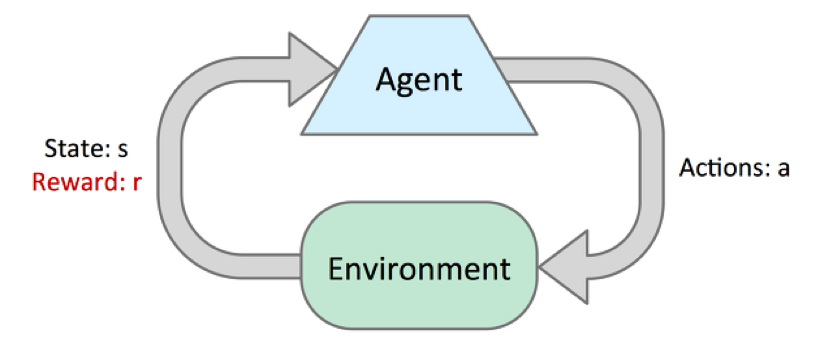

agent는 현재 상태만을 보는데, game score는 actions과 observations 전체 sequence에 따라 달라지기 때문에(즉 현재만이 아닌 미래의 보상도 고려해야 함) 현재만 보고 action을 결정하긴 어렵다.

즉 현재 screen $x_t$만으로는 현재 상황을 온전히 이해하기 힘들기 때문에 sequence $s_t = x1, a1, x2, ..., a_{t-1}, x_t$를 고려하기로 한다.  (state와 비슷한 개념으로 이해)  
여기서 모든 sequence의 time-step이 유한하므로(finite) `Markov decision process(MDP)`가 등장한다. 각 sequence가 별개의 상태이기 때문에(즉 과거와 미래가 독립) 이를 통해 뒤에 나오는 standard RL methods 적용이 가능하다.


$\gamma$ = time-step마다 미래 보상이 영향을 주는 정도(시점이 멀어질수록 작아진다) 라고 하면 보상 함수 $R_t$는 다음과 같다.  
$$ R_t = \sum_{t'=t}^{T}\gamma^{t'-t}r_{t'}$$ 

**Q-function이란?**  

`미래 보상의 총합을 구하는 함수`로, $s_t$에서 $a_t$를 취했을 때 얻을 수 있는 최대값인 optimal action-value function $Q^*(s,a)$ 은 다음과 같다.  

$$ Q^*(s,a) = max_\pi E[R_t|s_t=s, a_t=a, \pi]$$  
($\pi$ : $s_t$에서 $a_t$를 매핑해주는 policy)

위 식은 Bellman equation에 의해 next time-step에서 optimal한 $Q^*$를 안다면 다음과 같이 표현할 수 있다.  

$$ Q^*(s,a) = E_{s'~\epsilon}[r+\gamma max_{a'}Q^*({s'}, {a'})|s,a]$$  

그러나 실제로는 매 sequence마다 action-value function이 다르기 때문에 아래와 같이 approximate한 function을 사용해야 한다. 
$$Q(s,a;\theta) \approx Q^*(s,a)$$  

위는 linear function이고, non-linear하게 loss function을 최소화시키는 방향으로 학습하는 경우도 있다. (gradient 식은 자세히 이해하기 어려워 생략한다.) 최종적으로 Q-learning에 도달한다.


---
**Q-learning의 몇 가지 특성을 살펴보면,**  

- `model-free` : emulator의 sample로, 즉 environment $\epsilon$과 별도로 작동한다.
- `off-policy` : state 공간을 탐색할 수 있게 $1-\epsilon$ 확률은 $a=max_aQ(s,a;\theta)$에서 탐사하고, $\epsilon$ 확률은 랜덤하게 개척하도록 한다.  
→ 데이터 활용성이 떨어지는 걸 방지할 수 있다.

# 3. Related Work

가장 성공적인 강화학습이라고 알려진 TD-gammon은 Q-learning과 유사한 강화학습과 multi layer perceptron with one hidden layer를 사용하였다. 그러나 이는 backgammon에서만 유효했던 접근이었다.  
*Why?*  
model-free, non-linear function approximators, off-policy learning → 발산하는 문제를 야기  
linear function approximators가 낫다고 알려져왔다.

---
최근 들어 DNN+강화학습이 다양하게 시도되고 있다. 

- Boltzmann machines로 value function과 policy 추정
- gradient temporal-difference methods으로 fixed policy with nonlinear function approximators, control policy with linear function approximation 계산
- neural fitted Q-learning(NFQ) : RPROP 알고리즘을 사용하여 Equation 2에서 loss function의 sequence 최적화,  
batch update로 방대한 계산량과 deep autoencoders로 purely visual input 사용 

Atari 2600은 linear function approximation과 generic visual features를 적용한 강화학습 플랫폼으로 사용되는데, 아래와 같은 사항들을 통해 개선되었다.

- tug-of-war 사용으로 대량의 features에서 저차원 투영 
- HyperNEAT evolutionary architecture
- training repeatedly

# 4. Deep Reinforcement Learning

최근 computer vision과 speech recognition의 성과는 방대한 학습 데이터를 학습한 DNN의 결과였다. `raw input`과 `lightweight updates based on SGD`가 그것이다.  

여기서 **experience replay**라는 이 논문의 핵심 개념을 도입한다.

### experience replay
experience $e_t = (s_t, a_t, r_t, s_{t+1})$   
memory $D = e_1, .., e_N$  

여기서 experience를 직관적으로 해석하자면 아래와 같다.  
><q>어떤 상태에서 어떤 행동을 해서 다음에 어떤 상태인지, 그 때 얻어지는 보상은 어떠한가?</q>

time-step별 experience를 저장해둔 memory D에서 `랜덤하게 뽑아` Q-learning updates 혹은 `minibatch updates`를 진행한다.   
이렇게 experience replay를 진행한 후 agent는 $\epsilon$-greedy policy를 통해 선택한 action을 실행한다. (앞서 언급한 off-policy라고 이해)

이 방식은 아래와 같은 이점이 있다.

1. 더 많은 $e_t$가  가중치 업데이트에 사용되기 때문에 data efficiency가 높아진다.
2. 랜덤 샘플링으로 상관성을 깨주기 때문에 업데이트의 효율을 높여준다.
3. off-policy의 필요성을 만족시켜준다 : on-policy일 경우, 현재 파라미터는 자신의 학습 방향 안에서만 다음 샘플을 결정할 것이다. 예를 들어 파라미터가 left action을 취한다면 다음 샘플은 왼편의 데이터 안에서만 나올 것이다.  
experience replay를 통해 이와 같은 oscillation이나 divergence를 방지할 수 있다. (behavior distribution이 균형을 이룰 수 있다.)

실제로는 메모리의 한계로 인해 마지막 N개의 experience만을 저장하고 uniform sampling이기 때문에 모두 동일한 weight를 가진다는 한계를 지닌다.

---
**Preprocessing**  
raw Atari frames로 진행하려면 계산량이 방대하기 때문에 차원을 줄이기 위해 전처리 과정을 거친다.  
RGB → gray-scale, down-sampling (square cropping)

---
**사용한 architecture(DQN)를 살펴보면,**

각 state에서 가능한 모든 action의 Q-values를 한번의 forward pass로 계산 가능하다.  
architecture는 다음과 같다.
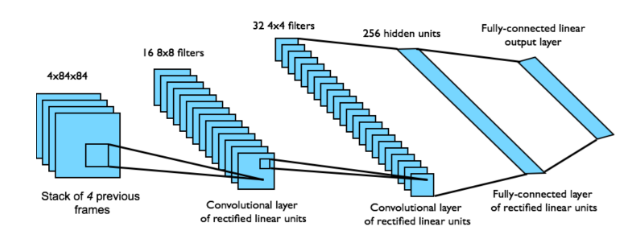

# 5. Experiments

network architecture와 알고리즘, hyperparameters 모두 동일하게 세팅하였고 어떠한 게임 관련 정보도 제공하지 않았다. 

- reward structure : 게임별로 score의 scale이 달라서 양의 보상은 1, 음의 보상은 -1, 아니면 0으로 변경해주어 scale을 제한시켜 학습을 용이하게 하였다.
- 32 batch size의 RMSProp 알고리즘 사용, behavior policy의 $\epsilon$값은 million frames까지는  1~0.1로 두었고 이후에는 0.1로 고정시켰다.
- frame-skipping : k번째(k=4) frame에서 action을 선택한 후 skipped frames에서는 마지막 action을 반복하여 runtime은 증가하지 않고 k배 많은 게임을 rough하게 play 시켰다. 

---
**training and stability**

지도학습에서는 validation set으로 모델을 평가하기 쉬우나 강화학습에서는 정확한 평가가 어렵다. noise가 심한 total reward 평균에 비해, policy의 action-value function Q를 척도로 측정한 결과 smooth하게 증가하였다.
실험에서 Q-values가 발산하는 경우도 없었기 때문에 이 architecture가 강화학습과 SGD를 이용하여 Neural Network 학습이 가능하다고 평가할 수 있다.

# 6. Conclusion

이 논문은 강화학습을 접목하기 위한 새로운 딥러닝 모델을 소개하고자 하였고, raw input만으로 Atari game에서 control policy 학습이 가능한 것을 입증하였다. 또한 SGD에 Experience replay를 적용한 Q-learning을 도입하였고, 이는 놀라운 결과를 낳은 것이 분명하다.

# 참고자료

1. https://mangkyu.tistory.com/60 
2. http://sanghyukchun.github.io/90/
3. https://github.com/tobigs-datamarket/tobigs-13th/blob/master/8wk_%EA%B0%95%ED%99%94%ED%95%99%EC%8A%B5/%EA%B0%95%ED%99%94%ED%95%99%EC%8A%B5_13%EA%B8%B0%20%EC%9D%B4%EC%9E%AC%EB%B9%88.ipynb (13기 우수과제 참고)
4. https://jeinalog.tistory.com/20 
5. https://brunch.co.kr/@kakao-it/73 